# Bathymetry: Data for the Shallow Water Equations

## GEOS518 Final Project - Fall 2021

## Damyn Chipman

## December 16th, 2021

In [1]:
# Package Imports
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xa
import netCDF4 as nc

from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import matplotlib.patches as patchesModule
from scipy import interpolate as interpolateModule

In [2]:
# Helper Functions
def extractRegion(dataset, long_bounds, lat_bounds, step=10):
    res = (
        dataset['lon'][::step] \
        .where(dataset.lon >= long_bounds[0], drop=True) \
        .where(dataset.lon <= long_bounds[1], drop=True),
        dataset['lat'][::step] \
        .where(dataset.lat >= lat_bounds[0], drop=True) \
        .where(dataset.lat <= lat_bounds[1], drop=True),
        dataset['elevation'][::step, ::step] \
        .where(dataset.lon >= long_bounds[0], drop=True) \
        .where(dataset.lon <= long_bounds[1], drop=True) \
        .where(dataset.lat >= lat_bounds[0], drop=True) \
        .where(dataset.lat <= lat_bounds[1], drop=True)
    )
    return res

def getLongLatRectangle(long_bounds, lat_bounds, ec='r', fc='none', lw=3):
    return patchesModule.Rectangle((long_bounds[0], lat_bounds[0]), long_bounds[1] - long_bounds[0], lat_bounds[1] - lat_bounds[0], edgecolor=ec, facecolor=fc, lw=lw)

### Outline

1. Introduction

2. Model Description

3. Data Needs

4. Calibration

5. Numerical Experiment Design

6. Conclusion

### 1. Introduction

About 75% of the Earth's surface is covered by water, in the Earth's oceans, rivers, and seas. Events in one place of the world can severly impact another. An earthquake in Japan can trigger a tsunami in the Pacific. A hurricane over one part of the ocean impacts several different land masses. Or, at the extreme, an asteroid impact in the ocean could trigger regional to world-wide devestating impacts. Thus, it is crucial to be able to both 1) know the current conditions of the ocean and it's climate, and 2) be able to predict the near to distant future based on the current situation. This is where climate and ocean modeling enter.

Accurate simulations of the ocean and climate depend on various components. They depend on accurate weather and bathymetry data. They depend on accurate physics models to predict future states. And they depend on numerical methods implemented on fast supercomputers in order to compute the future in time for us to react to it. A model is useless if it takes longer to compute the future than for the future to arrive. Thus, it is not uncommon for complex physical models to make reasonable assumptions to generate a model that has a faster time to solution. This is where pieces of ocean models like the shallow water model enters the scene.

The shallow water equations is a surface model that approximates water height across an ocean or other large body of water. The primary assumption is that the horizontal scale (across the surface of the Earth) is much larger than the depth of water. The shallow water model can be used to model tsunami propagation from an earthquake or debris flow like mud slides. It is also used in planetary defense models in the case of large extraterrestial objects splashing down in the ocean that could cause regional tidal effects.

### 2. Model Description

#### 2.1 General Shallow Water Equation Model

The shallow water equations (SWE) is a set of equations that model the depth of water over a space where the horizontal scale (across the surface of the Earth) is much larger than the depth of the water. It can be derived from the Navier-Stokes equations of mass and momentum conservation in fluids by depth integrating over the depth component of momentum.

The SWEs model the water hieght as a function of space and time, $h(x,y,t)$, as well as the latitudinal and longitudinal components of velocity, $u(x,y,t)$ and $v(x,y,t)$. In their conservative form, the SWE are:

$$\begin{align}
\frac{\partial \textbf{q}}{\partial t} + \nabla \cdot \textbf{F}(\textbf{q}) &= \textbf{s}
\end{align}$$

where

$$\begin{align}
\textbf{q} =
\begin{bmatrix}
h \\
hu \\
hv \\
\end{bmatrix},\ \ \ 
\textbf{F}(\textbf{q}) = 
\begin{bmatrix}
hu & hv \\
hu^2 + \frac{1}{2} g h^2 & h u v \\
h u v & hv^2 + \frac{1}{2} g h^2 \\
\end{bmatrix},\ \ \ 
\textbf{s} = 
\begin{bmatrix}
0 \\
-g h \frac{\partial b}{\partial x} \\
-g h \frac{\partial b}{\partial y} \\
\end{bmatrix}
\end{align}$$

with

$$\begin{align}
h(x,y,t) &= \text{Water Surface Hieght} \\
u(x,y,t) &= \text{Latitudinal Velocity (x)} \\
v(x,y,t) &= \text{Longitudinal Velocity (y)} \\
b(x,y) &= \text{Bathymetry (Land Elevation Underwater)} \\
g &= \text{Gravitational Constant} \\
\end{align}$$

Below is a diagram of the SWE system along the latitudinal (x) direction and depth (z), with the longitudinal direction going into the screen:

<img src=assets/swe_model.pdf />

Typically, the height $h$ is measured from the surface of the Earth to the surface of the water. A "sea-level" is established as $z = 0$. The bathymetry is the variation of the Earth's elevation underneath the water, and is a measured quantity (more on this later).

Together, the SWEs form a hyperbolic system. This system can be solved using simple to complex numerical methods, such as a simple finite difference scheme on a square grid to an unstructured mesh solved through a finite volume or element approach. For example, in the Spring of 2021, I did a "physics in a box" experiment using an unstructured finite volume method in MATLAB:

| Gaussian Wave in a Box | Incoming Wave |
| :-: | :-: |
| ![alt](assets/gaussian.gif) | ![alt](assets/wave.gif) |

The write up, which includes a derivation of the SWE from the Navier-Stokes equations and details on the "physics in a box" experiments, can be found on my Github: https://github.com/DamynChipman/ME530FinalProject.

In this report, we will look at how this model can be improved through the physics and math behind the model, as well as more sophisicated means to model the SWEs.

#### 2.2 A Dispersive Shallow Water Model

A model is only as good as it's physics. Recent developments on the SWE model has lead to a higher-order physics model that includes dispersive effects in the water surface. We can express this dispersive SWE model as the following:

$$\begin{align}
\frac{\partial \textbf{q}}{\partial t} + \nabla \cdot \textbf{F}(\textbf{q}) &= \textbf{s} + \textbf{f}
\end{align}$$

where

$$\begin{align}
\textbf{q} =
\begin{bmatrix}
h \\
hu \\
hv \\
\end{bmatrix},\ \ \ 
\textbf{F}(\textbf{q}) = 
\begin{bmatrix}
hu & hv \\
hu^2 + \frac{1}{2} g h^2 & h u v \\
h u v & hv^2 + \frac{1}{2} g h^2 \\
\end{bmatrix},\ \ \ 
\textbf{s} = 
\begin{bmatrix}
0 \\
-g h \frac{\partial b}{\partial x} \\
-g h \frac{\partial b}{\partial y} \\
\end{bmatrix}, \ \ \ 
\textbf{f} =
\begin{bmatrix}
0 \\
\frac{\alpha - 1}{\alpha} g h \frac{\partial \eta}{\partial x} + d_x \\
\frac{\alpha - 1}{\alpha} g h \frac{\partial \eta}{\partial y} + d_y \\
\end{bmatrix}
\end{align}$$

This dispersive SWE model adds a dispersive term $\textbf{f}$ which involves the vector field $\textbf{d} = [d_x, d_y]^T$. By itself, $\textbf{f}$ acts as another source term in the hyperbolic system. However, solving for the field $\textbf{d}$ involves solving a 2nd order PDE involving an elliptic operator $\mathcal{T}$:

$$\begin{align}
h (\textbf{I} + \alpha \mathcal{T}) \textbf{d} = \frac{g}{\alpha} \nabla \eta + \mathcal{Q}_1(\textbf{u})
\end{align}$$

The operators $\mathcal{T}$ and $\mathcal{Q}_1$ are rather complicated, and the details are found in [Popinet, 1]. In addition, other formulations for this dispersive term can be found in [Bonneton, 2] and [Lannes, 3]. Regardless, adding the dispersive term involves solving a non-homogeneous elliptic PDE. Standard methods of doing so are using iterative solvers like geometric or algebraic multigrid, or Krylov methods like GMRES. We are developing a direct solver based off the hierarchical Poincaré-Steklov (HPS) method. Details of this method can be found in [Martinsson, 4].

#### 2.3 Numerical Models of the Shallow Water Equations

With regard to implementation of these solvers, including the original hyperbolic system, there are various codes that can be used to model the SWEs. One of the gold standards when it comes to finite volume methods is Clawpack, originally developed by Randall LeVeque [5]. Extensions include codes that introduce adaptive mesh refinement (AMR) like AMRClaw and GeoClaw. GeoClaw is specifically designed for geophysical flows like the ones modeled in the SWEs. Another extension includes ForestClaw which uses the finite volume methods included in Clawpack, but on a quad- or oct-tree mesh.

##### 2.3.a Clawpack, GeoClaw, and ForestClaw

Clawpack (conservation laws package) is a collection of finite volume methods for linear and nonlinear hyperbolic systems. Clawpack can solve hyperbolic systems in 1, 2, and 3D. It uses high-resolution Godunov-type methods and is written in Fortran and Python. It is parallel compatible with distributed memory parallelism and scales well on clusters of CPUs.

Clawpack has been extended with additional capabilities like AMR. AMRClaw introduces adaptive mesh refinement into the Clawpack FV methods. GeoClaw includes the same capabilities of AMRClaw, but has kernels and FV methods designed specifically for geophysical flows [6].

Regarding adaptive mesh refinement, there are two flavors of AMR, patch-based and tree-based. Patch-based AMR (or level-based) collocates zones of differing levels of refinement. This allows the user to specifically place more refined grids in desired locations. Tree-based AMR builds a grid by refining quadrants (in 2D, octrants in 3D) down to the level of precision desired by the user.

<img src=assets/amr-meshes.jpg />

Each flavor of AMR has it's own advantages and disadvantages, which we won't go into detail in this write up. The point in introducing the different flavors of AMR is to point out the difference between the AMR in the AMRClaw and GeoClaw packages versus the AMR that is implemented in ForestClaw.

ForestClaw builds upon the routines in Clawpack by introducing tree-based AMR. The ForestClaw code is developed by Boise State's Donna Calhoun and calaborators. As part of my dissertation, I am developing an elliptic PDE solver for ForestClaw. ForestClaw builds on top of the popular `p4est` library for handling the mesh. ForestClaw acts as a PDE layer on top of `p4est` by introducing the hyperbolic (and with my dissertation, elliptic) PDE solvers [7, 8].

##### 2.3.b MOOSE Finite Element Framework

Another very user friendly code is the Multiphysics Object Oriented Simulation Environment (MOOSE) developed by Idaho National Lab. It is a C++ object-oriented code designed to solve PDEs on unstructured meshes using a robust finite element solver. It employs a kernel approach for each term in the weak form of the PDEs, where each kernel/term is a class in the C++ code. For more info, see [9].

Over the course of the semester, I have been developing a MOOSE application called Goldfish, standing for the GeOphysicaL Domain Finite element Simulation Hub. MOOSE apps are supposed to be named after animals... It can be found here: https://github.com/DamynChipman/Goldfish. Goldfish includes geophysical kernels like `HeatDiffusion` and `LandscapeDiffusion`. I have also been working on finite volume and finite element kernels for the shallow water equations, though these are very much still a work in progress.

### 3. Data Needs

The SWEs require inputs into the system in order to fully solve the problem. As a PDE, it needs boundary conditions and initial conditions. In addition, the actual model needs information on the ocean floor topography, called bathymetry. Finally, if we are to use the dispersive SWE model, than we will need any input those operators require, but for the purpose of this write up, we will ignore these.

#### 3.1 Boundary Conditions

As the SWE typically model tsunami flow, the typical boundaries we would need to model are land boundaries or outflow boundaries at the edges of our simulation domain.

Outflow boundaries are the simplest, as we can just allow a wave to propagate outside the simulation domain. In most codes/models, this is a standard boundary condition and we can turn on a flag to do so at the necessary sides.

Land boundaries are much more tricky. If we are modeling a situation where the water runs up into dry land, like on a beach, then we need to model what is called wetting. This looks like having cells in our simulation domain that allow for a water height of zero. This must be coded in seperate from the solution kernel. Other land boundaries might consist of a wall or container. In this case, modeling is simplier, as we can enforce a zero flux BC on these cells.

#### 3.2 Initial Conditions

In order to model wave propagation, we need to start with a wave. There are a couple different ways to input the initial or driving dynamics into the SWEs.

The first would be imposing an initial state for each of the variables at the start of the simulation domain. This could look like a dam-break problem, where we set a part of the domain to a specific height with zero velocity, then advance the state from there. The dam-break problem is a common test problem for the SWEs.

More realistic and interesting problems consist of cases where some other force drives the water. This is the case in an earthquake driven tsunami. Another example could be an asteroid splashing down and causing the initial state that cases the tsunami.

For the asteroid case, in order to model this, an external dynamics code would need to model the asteroid and the fluid, likely with a full Navier-Stokes model. This has been done by scientists from Lawrence Livermore National Lab (LLNL) [10].

For the earthquake case, the most common approach is to not set initial conditions, but to drive the problem using an earthquake source term on the RHS of the SWEs. There are various kernels and wavelets that are used to model earthquakes, but anyone of them would work to drive the dynamics of the simulation.

#### 3.3 Bathymetry

Finally, regardless of the dynamics, if the simulation is done in the ocean, then there is ocean bathymetry. This appears in the SWEs on the RHS as a source term:

$$\begin{align}
\textbf{s} = 
\begin{bmatrix}
0 \\
-g h \frac{\partial b}{\partial x} \\
-g h \frac{\partial b}{\partial y} \\
\end{bmatrix}
\end{align}$$

The bathymetry $b(x,y)$ is a 2D surface that represents the Earth's surface topography. This is provided from a measured dataset. A common and open source dataset is the GEBCO gridded bathymetry data, and can be found here [11]. GEBCO provides various formats for this data, including a NetCDF format. The GEBCO bathymetry dataset is provided across the entire Earth at a 15 arc-second interval grid.

The following Python cells read in the NetCDF file from GEBCO, pick a region, and plot the dataset with the selected region. A similar process would need to be done in order to read in bathymetry data for any simulation.

In [3]:
# File Information
filepath = './data/gebco_2021_sub_ice_topo/'
filename = 'GEBCO_2021_sub_ice_topo.nc'

In [4]:
# Import Data
dataset = xa.open_dataset(filepath + filename)

In [5]:
dataset

<xarray.Dataset>
Dimensions:    (lon: 86400, lat: 43200)
Coordinates:
  * lon        (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat        (lat) float64 -90.0 -89.99 -89.99 -89.99 ... 89.99 89.99 90.0
Data variables:
    crs        |S1 ...
    elevation  (lat, lon) int16 ...
Attributes: (12/36)
    title:                           The GEBCO_2021 Grid - a continuous terra...
    summary:                         The GEBCO_2021 Grid is a continuous, glo...
    keywords:                        BATHYMETRY/SEAFLOOR TOPOGRAPHY, DIGITAL ...
    Conventions:                     CF-1.6, ACDD-1.3
    id:                              DOI: 10.5285/c6612cbe-50b3-0cff-e053-6c8...
    naming_authority:                https://dx.doi.org
    ...                              ...
    geospatial_vertical_units:       meters
    geospatial_vertical_resolution:  1.0
    geospatial_vertical_positive:    up
    identifier_product_doi:          DOI: 10.5285/c6612cbe-50b3-0cff-e053-6c8...
    references:                      DOI: 10.5285/c6612cbe-50b3-0cff-e053-6c8...
    node_offset:                     1.0

In [6]:
step = 10 # !! This needs to be used !! At step = 10, RAM usage is at 2.35GB
world_elevation = dataset['elevation'][::step, ::step]

In [7]:
# Extract Region
long_bounds = np.array([
    -150, -115
])
lat_bounds = np.array([
    25, 50
])

region_lon, region_lat, region_elevation = extractRegion(dataset, long_bounds, lat_bounds, step=10)

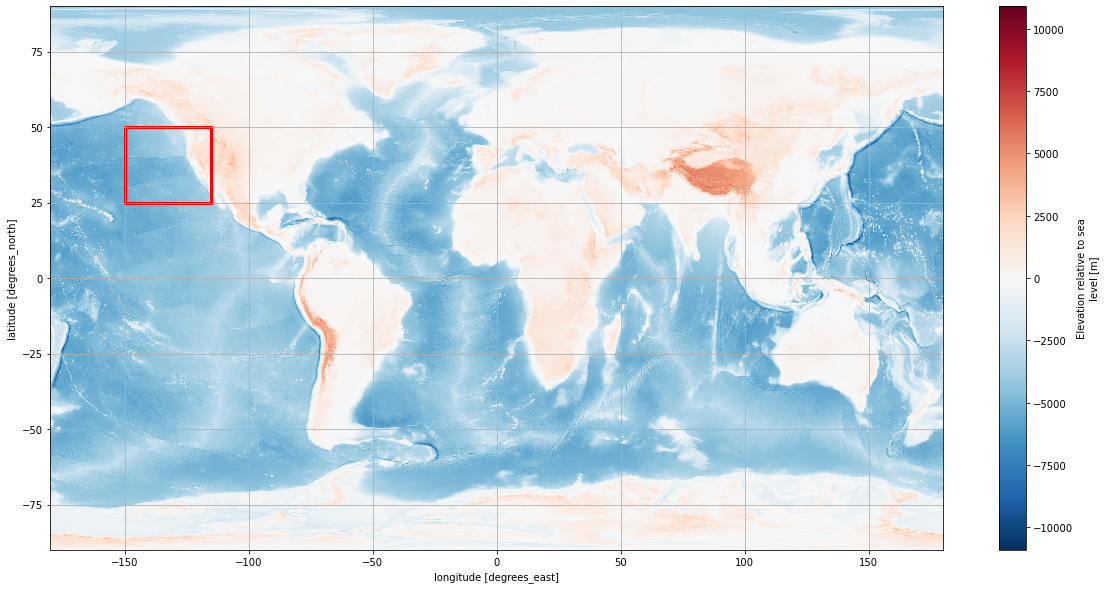

In [8]:
fig, ax = plt.subplots(1, figsize=(20,10))
world_elevation.plot(ax=ax)
rect = getLongLatRectangle(long_bounds, lat_bounds)
ax.add_patch(rect)
plt.grid()

Having the regional data needed for a simulation, it would then need to be written into any format that GeoClaw, ForestClaw, or MOOSE can use.

### 4. Calibration

The simple shallow water model does not include any model parameters that need to be tuned or adjusted. In the more complex dispersive model, the parameter $\alpha$ is a model hyper-parameter that would need to be tuned. This could be done by comparing known analytical solutions to runs of the model. Another way of tuning $\alpha$ would be to run an "physics in a box"-like experiment to fit $\alpha$ to the observed data.

Regarding data, the bathymetry data is provided from GEBCO at every 15 arc-second interval. If our model was running on a more fine (or coarse) grid, we would need to be able to interpolate between the experimental data to any model grid location. Python's `scipy` model has a 2D interpolation module that would be able to do this, or any of the numerical models would have to be able to interpolate between the bathymetry data. As most of the considered numerical models use adaptive mesh refinement, they would need some robust interpolation routines to this kind of data processesing.

### 5. Numerical Experiment Design

Now we look at a proposed numerical experiment using GeoClaw. We pick GeoClaw because it is the most relevant and most developed code we've looked at for solving the SWEs. The MOOSE kernels are still being built, and the elliptic solver in ForestClaw for the dispersive SWE model is in development. We will look at an asteroid generated tsunami simulation over a specific region. We'll look at the problem specifically with GeoClaw, but the data inputs and other considerations will roll over to either ForestClaw or MOOSE when they are ready to solve the dispersive SWEs.

#### 5.1 Real World Problem

NASA recently launched it's DART Mission. DART stands for Double Asteroid Redirection Test. The goal of the DART mission is to use a kinetic impactor technique to change the motion of an asteroid in space. The asteroid in question - Didymos - poses no threat to Earth. The mission serves as a practical example of a possible solution to an unforeseen asteroid that could impact Earth [12].

Let's consider a scenario in which an asteroid flies by undetected or too soon for any mitigation techniques. The asteroid will inevitably impact Earth. It will splash down somewhere in the Pacific Ocean, off the west coast of the United States. The question we, as computational geophysicists, is to figure out the consequences of the impact. We need to know what to expect in order to inform local authorities about any potential dangers to society.

We know that the asteroid is large enough to not break apart during atmospheric entry, and is large and moving fast enough to cause significant tidal effects. We also have an idea as to where it will impact. What we don't know is how large will the waves be that the impact causes, and how much of a threat they will be. Where will the waves hit shoreline? How big will they be? How long do we have before they arrive?

#### 5.2 Hypothesis

Given an initial splash-down location, we can simulate the initial splash-down with a high fidelty hydrodynamics code in order to get the water height profile after splash-down. Once the initial water height profile is known, we can use the shallow water equations to propagate the waves over the oceanic domain. We can infer the time and location of the waves' influence on our shorelines and provide authorities with the necessary information to make crucial decisions.

#### 5.3 Numerical Experiment

There are three parts to this numerical simulation:

1) Modeling the asteroid entering the atmosphere to know the speed, temperature, and state of the asteroid

2) Modeling the splash-down to understand the water height and subsequent effects, and

3) Modeling the wave propagation over the ocean to determine if any shoreline faces any danger.

Parts 1 and 2 would require code that is outside the scope of this project. However, they would be necessary in order to inform GeoClaw of the initial conditions in order to propagate the waves out. From here, we assume that we have run some other code in order to get an initial water height everywhere in our domain, primarily in the region where the asteroid impacts. An example of an output of a code like this can be seen below (an example of the 3D Geodyn code developed by LLNL):

<img src=assets/asteroid-splash-down.png />

<figcaption align=center><b>https://presentations.copernicus.org/EGU2020/EGU2020-10579_presentation.pdf</b></figcaption>

With an initial state, we can now look at running GeoClaw to continue the wave propagation. A GeoClaw run can be setup via a Python script `setrun.py`. In `setrun.py`, the user specifies all the input parameters needed for a run of GeoClaw. This is where the initial state can be input, the bathymetry can be read in, and the space and time domain parameters can be set. In addition, any other physics considerations can be set, like water run up parameters and equation kernels.

With the simulation set up, we would need to then run the simulation. This is assuming we have enough time before projected splash-down to run a full-fidelity simulation. If not, then some adjustments could be made like a coarser spatial or time domain.

Finally, having run the simulation, we would need to specify any locations that the model predicts would be under threat of significant water impacts. The outputs of the model, and information we would pass on to authorities, would be the time and location of large enough waves to cause damage. This would give authorities the information necessary to make mitigation decisions to protect life and property. Crisis averted!

### 6. References

1. S. Popinet. A quadtree-adaptive multigrid solver for the Serre–Green–Naghdi equations. J. Comput. Phys., 302:336–358, 2015.

2. P. Bonneton, F. Chazel, D. Lannes, F. Marche, and M. Tissier. A splitting approach for the fully nonlinear and weakly dispersive Green-Naghdi model. J. Comput. Phys., 230(4):1479–1498, 2011.

3. D. Lannes and F. Marche. A new class of fully nonlinear and weakly dispersive Green–Naghdi models for efficient 2D simulations. J. Comput. Phys., 282:238–268, 2015.

4. P. Martinsson. The hierarchical Poincar ́e-Steklov (HPS) solver for elliptic PDEs: A tutorial. arXiv preprint arXiv:1506.01308, 2015.

5. http://www.clawpack.org

6. http://www.clawpack.org/geoclaw.html

7. http://www.forestclaw.org/ForestClaw/index.html

8. https://www.p4est.org

9. https://mooseframework.inl.gov

10. https://presentations.copernicus.org/EGU2020/EGU2020-10579_presentation.pdf

11. https://www.gebco.net/data_and_products/gridded_bathymetry_data/

12. https://www.nasa.gov/planetarydefense/dart